<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/1.0-data-understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

Hip and knee osteoarthritis is a leading cause of disability and source of societal cost in older adults. Global prevalence of osteoarthritis is increasing and the burden of the disease will rise. The medical cost of osteoarthritis in various high-income countries has been estimated to account for between 1% and 2.5% of the gross domestic product of these countries, with hip and knee joint replacements representing the major proportion of these health-care costs.

Joint replacement surgery is a clinically relevant and cost-effective treatment for end-stage osteoarthritis. The characteristics of end-stage osteoarthritis include joint pain, which disrupts normal sleep patterns and causes a severe reduction in capable walking distance and marked restriction of daily activities. Hence, the aim of knee and hip replacements is to alleviate pain and disability in daily functioning.

However, up to 25% of patients presenting for total joint replacement continue to complain of pain and disability 1 year after well performed surgery. With data available on thousands of patients, the question arises to what extent it is possible to predict treatment success. This could be useful in supporting doctors in deciding whether knee replacement is indicated, and could help give patients a more personalised assessment of what to expect of treatment.

# CRISP-DM phase 1 and 2: Business and Data Understanding

This is day 1 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/README.md).

## Learning objectives


### Business Understanding
- Determine business objectives
- Assess situation
- Determine data mining and machine learning goals


### Data Understanding: descriptive statistics
- Explore Y
- Define Y with results exploration combined with clinical knowledge
- Assess missing values
- Assess data structure
- Explore correlation plot (X, Y)

### Python
- [Using pandas to explore data](https://realpython.com/pandas-python-explore-dataset/)
- [Fundamental stats to describe your data](https://realpython.com/python-statistics/)
- [Reading and writing files with pandas](https://realpython.com/pandas-read-write-files/)
- Be aware of some `pandas` pitfalls:
  - Know how `pandas` uses copies by default and good practice not to replace in-place
  - Use Int64 for N/A


## Business Understanding
Assume that primary reasons to replace a knee is to **i) reduce pain**, and **ii) improve daily functioning**. The dataset contains the various patient-reported outcome measures that can be used to measure the outcome along these two dimenions:
- Oxford Knee Score (OKS): a 12-item questionnaire that assess daily functioning c.q. disability due to knee osteoarthritis. Items are scored from [0,4], where higher is better (no disability).  
  - OKS question on pain and night pain, both on scale from [0,4]
  - OKS , higher is better. The OKS is a 12-item questionaire that assess daily functioning c.q. disability.
- EQ5D: generic quality of life PROMs along 5 dimensions on a 3-point Likert scale [1,3], lower is better. Dimensions are problems activity, anxiety, discomfort, mobility and self-care.
- EQ-VAS: general reported health on a scale from [0,100], higher is better.

We will explore the PROMs data to see which target variable Y is meaningful to assess the outcome of knee replacement. Note PROMs are measured at T0 (prior to surgery) and T1 (six months after surgery).
- [NHS PROMs methodology](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/nhs/proms_guide_v12.pdf)
- [NHS PROMs data dictionairy](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/nhs/proms_data_dictionary.pdf)

## Data Understanding


### Getting started with pandas

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

In [2]:
# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# alternatively, if you have cloned this repository, read local file
# df = pd.read_parquet('../data/interim/knee-provider.parquet')

#### Display datatypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139236 entries, 0 to 139235
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   provider_code                 139236 non-null  category
 1   procedure                     139236 non-null  category
 2   revision_flag                 139236 non-null  uint8   
 3   year                          139236 non-null  category
 4   age_band                      129834 non-null  category
 5   gender                        129834 non-null  float32 
 6   t0_assisted                   139236 non-null  uint8   
 7   t0_assisted_by                139236 non-null  uint8   
 8   t0_symptom_period             139236 non-null  uint8   
 9   t0_previous_surgery           139236 non-null  uint8   
 10  t0_living_arrangements        139236 non-null  uint8   
 11  t0_disability                 139236 non-null  uint8   
 12  heart_disease                 

### Describing the data

In [4]:
# if you have wide tables, adjust these settings to enable scrolling
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

#### pd.DataFrame.describe()

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revision_flag,139236.0,0.04,0.19,0.00,0.00,0.00,0.00,1.00
gender,129834.0,1.57,0.49,1.00,1.00,2.00,2.00,2.00
t0_assisted,139236.0,1.92,0.82,1.00,2.00,2.00,2.00,9.00
t0_assisted_by,139236.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t0_symptom_period,139236.0,2.65,1.05,1.00,2.00,2.00,3.00,9.00
t0_previous_surgery,139236.0,1.97,0.67,1.00,2.00,2.00,2.00,9.00
t0_living_arrangements,139236.0,1.35,1.04,1.00,1.00,1.00,1.00,9.00
t0_disability,139236.0,1.81,1.59,1.00,1.00,2.00,2.00,9.00
heart_disease,139236.0,8.25,2.33,1.00,9.00,9.00,9.00,9.00
high_bp,139236.0,5.46,3.97,1.00,1.00,9.00,9.00,9.00


### Explore possible outcomes Y

In [6]:
proms = ['oks_t0_score', 'oks_t1_score', 'oks_t0_pain', 'oks_t1_pain', 'oks_t0_night_pain', 'oks_t1_night_pain', 't0_discomfort', 't1_discomfort', 't0_eq_vas', 't1_eq_vas', ]
df.loc[:,proms].describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
oks_t0_score,137567.0,19.0,7.7,0.0,13.0,19.0,24.0,48.0
oks_t1_score,136657.0,35.9,9.5,0.0,30.0,38.0,43.0,48.0
oks_t0_pain,139236.0,0.6,0.7,0.0,0.0,0.0,1.0,9.0
oks_t1_pain,139236.0,2.7,1.3,0.0,2.0,3.0,4.0,9.0
oks_t0_night_pain,139236.0,1.3,1.4,0.0,0.0,1.0,2.0,9.0
oks_t1_night_pain,139236.0,2.9,1.3,0.0,2.0,3.0,4.0,9.0
t0_discomfort,139236.0,2.6,1.4,1.0,2.0,2.0,3.0,9.0
t1_discomfort,139236.0,1.9,1.3,1.0,1.0,2.0,2.0,9.0
t0_eq_vas,139236.0,154.0,271.4,0.0,55.0,75.0,89.0,999.0
t1_eq_vas,139236.0,118.2,196.4,0.0,69.0,80.0,90.0,999.0


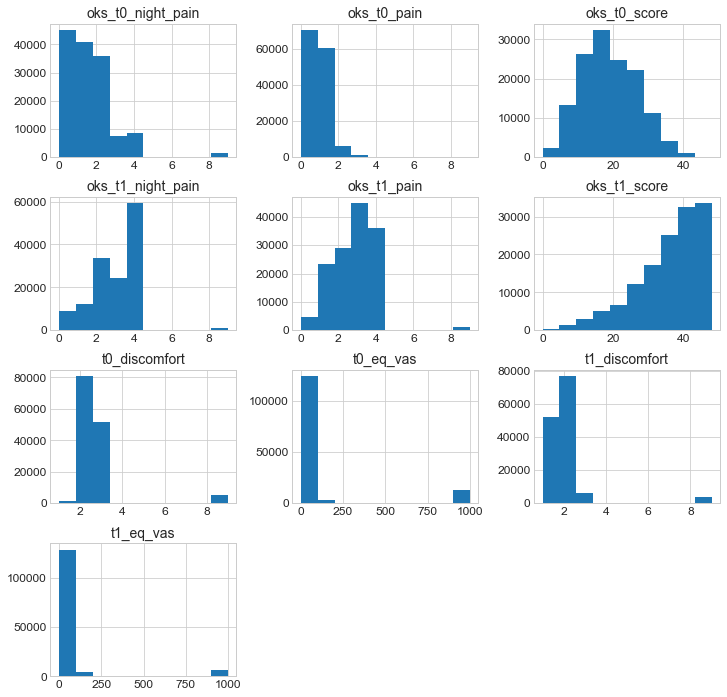

In [7]:
# inspect with histograms
df.loc[:,proms].hist(figsize=M);

### Missing values and sentinel values
The histograms shown earlier indicate [sentinel values](https://en.wikipedia.org/wiki/Sentinel_value) are used to encode missing values:
* `9` for individual OKS questions
* `999` for EQ VAS

In [8]:
df.loc[:,['t0_eq_vas', 't1_eq_vas']].apply(pd.value_counts).tail()

,t0_eq_vas,t1_eq_vas
97,391,882
98,444,1015
99,332,618
100,2707,4261
999,12961,6546


In [9]:
_no9 = [col for col in df.columns if col.startswith('oks_t') and not col.endswith('score')]
df.loc[:,_no9].apply(pd.value_counts)

,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t1_pain,oks_t1_night_pain,oks_t1_washing,oks_t1_transport,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs
0,70493,45021,810,740,17037,4765,60433,60103,18286,18877,24162,7612,4638,8955,356,360,3963,501,6235,42702,2484,1707,9043,3232
1,60701,40943,12189,31896,17499,59989,47425,48650,59140,40686,27235,46072,23471,12180,2283,5909,5110,7965,10319,23453,8443,4511,6134,8740
2,6171,35851,43630,72115,56402,50796,16080,24326,47021,32501,46012,58010,28987,33555,12700,32345,14790,23588,10525,30319,25129,7807,16628,26724
3,1340,7380,38234,23997,35763,19684,12158,4022,11494,35050,26975,21349,44799,24498,25157,46526,30372,53884,50910,30361,45873,34264,27699,42941
4,333,8737,44248,9138,11092,2549,1725,739,1939,10780,13509,4855,36051,59171,97502,52859,83740,52292,60150,11310,56295,90000,78727,56619
9,198,1304,125,1350,1443,1453,1415,1396,1356,1342,1343,1338,1290,877,1238,1237,1261,1006,1097,1091,1012,947,1005,980


### Example: volume per provider per year

In [10]:
# count number of providers
df.provider_code.unique().shape

(294,)

In [11]:
# volume per provider per year
volume_provider_year = df.groupby(['year', 'provider_code'])['procedure'].count().unstack()
volume_provider_year.iloc[:,0:20]

provider_code,ADP02,AHH,AVQ,NFH01,NN401,NN801,NQM01,NT202,NT204,NT205,NT206,NT209,NT210,NT211,NT212,NT213,NT214,NT215,NT218,NT219
year,,,,,,,,,,,,,,,,,,,,
2016/17,164,24,0,0,12,33,0,18,60,9,23,49,84,0,16,214,78,153,18,82
2017/18,236,30,0,0,7,43,10,22,75,6,28,62,73,17,50,335,112,11,27,94
2018/19,323,16,139,13,22,66,12,28,106,16,65,65,72,13,76,403,127,9,32,91


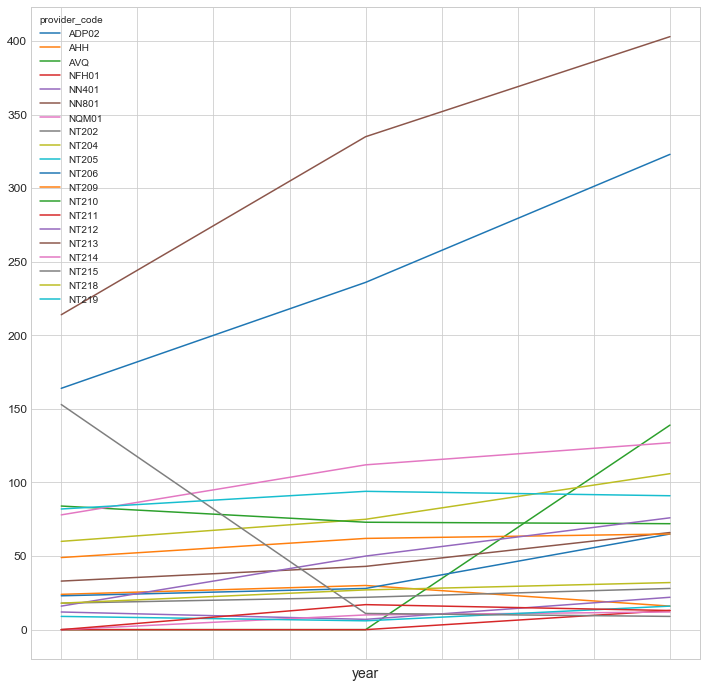

In [12]:
# first 20 providers in the data
volume_provider_year.iloc[:,0:20].plot(figsize=M);

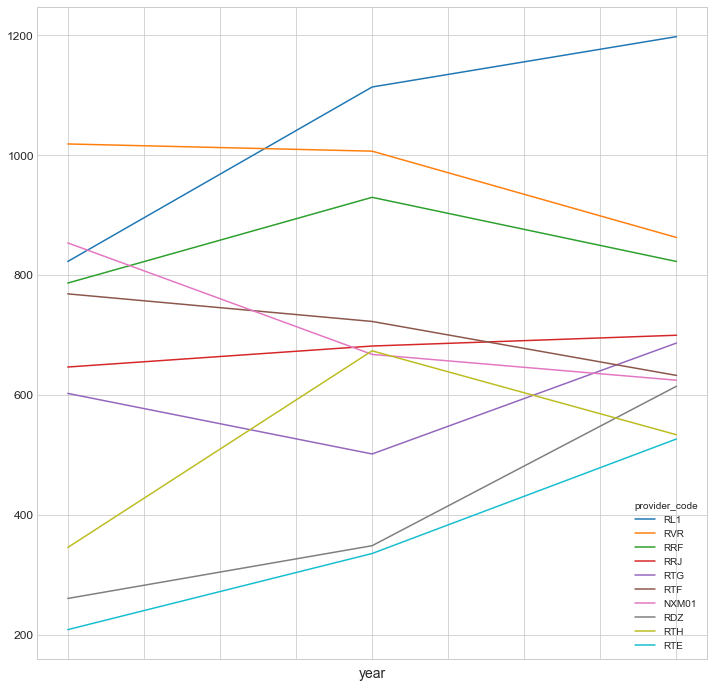

In [13]:
# select 10 largest providers by 2018/19
_year = (df.year == '2018/19')
top10 = df.loc[_year,:].groupby('provider_code').count()['procedure'].sort_values(ascending=False).head(10)
volume_provider_year.loc[:, list(top10.index)].plot(figsize=M);

### Discussion

#### **Question:** what are relevant considerations to handle NAs?
- imputation with mean/median?
- just drop all?

#### **Question:** what would you choose as the primary outcome Y?

## Explore Y

### Y = Improvement in Oxford Knee Score

Given the variance between the pre- and postoperative values, we choose Y as the improvement in the Oxford knee score, i.e.

$${\Delta} {OKS} = OKS_{T1} - OKS_{T0}$$

We now need to handle the missing values first, before proceeding with our analysis.


### Data preparation: first iteration

For now we will just drop all rows with one or more missing value. In the next iteration we will look into more sophisticated methods for imputing missing data.

#### Handling and replacing missing values in pandas
Up to now, pandas used several values to represent missing data: `np.nan` is used for this for float data, `np.nan` or `None` for object-dtype data and `pd.NaT` for datetime-like data. An experimental, new `pandas.NA` feature is introduced in version 1.0. Note that Google Colab still uses version 0.25 (as of 2020-03-15).

`.loc` and `.iloc` are the recommended way to access parts of a `pd.DataFrame`. Note that this **always returns as copy**. Hence, to replace values, best practice is to:
- make a new copy
- do the replacements in the copy with explicit assignment

Note that [pandas can handle missing values in integer columns recently](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html) (since version 0.24). This is still experimental, so be aware! Your options for handling missing values in integer columns are:
- Convert to `float64`, which is the most robust, old way to do it
- Convert to the new `Int64` dtype (note the capital `I`!)




In [14]:
# This DOES NOT work
df.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64').dtypes
df.loc[:,['t0_eq_vas', 't1_eq_vas']].head()

,t0_eq_vas,t1_eq_vas
0,80,999
1,999,95
2,999,98
3,999,60
4,75,80


In [15]:
# when using iloc or loc you need to specify a location to update with some value.
# explicitly make new copy
dfc = df.copy()
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']] = dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64')
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].head()

,t0_eq_vas,t1_eq_vas
0,80,<NA>
1,<NA>,95
2,<NA>,98
3,<NA>,60
4,75,80


In [16]:
# simarly, change 9 to N/A for OKS
dfc.loc[:,_no9] = df.loc[:,_no9].replace(9, np.nan).astype('Int64')
pd.concat([df.loc[:,_no9].isnull().sum(), dfc.loc[:,_no9].isnull().sum()], axis=1, keys=['df', 'dfc'])

,df,dfc
oks_t0_pain,0,198
oks_t0_night_pain,0,1304
oks_t0_washing,0,125
oks_t0_transport,0,1350
oks_t0_walking,0,1443
oks_t0_standing,0,1453
oks_t0_limping,0,1415
oks_t0_kneeling,0,1396
oks_t0_work,0,1356
oks_t0_confidence,0,1342


#### Dropping `NA`s

In [17]:
dfc.dropna(inplace=True)

#### Add `delta_oks_score`

In [18]:
print(f'Raw data:   {df.shape[0]} rows\nNo NA data: {dfc.shape[0]} rows\n # dropped:  {df.shape[0] - dfc.shape[0]} rows')
dfc['delta_oks_score'] = dfc.oks_t1_score - dfc.oks_t0_score

Raw data:   139236 rows
No NA data: 103486 rows
 # dropped:  35750 rows


#### Y by provider, year (using boxplots)

In [19]:
# calculate descriptive stats for delta_oks
dfc.groupby(['year', 'provider_code'])['delta_oks_score'].describe().head()

count   mean    std   min    25%   50%    75%   max
year    provider_code                                                     
2016/17 ADP02          118.0  16.87   9.38 -10.0  12.00  17.0  23.00  37.0
        AHH              5.0  19.60  12.18   0.0  17.00  24.0  25.00  32.0
        NN801           14.0  11.14   7.01  -5.0   9.00  10.0  16.75  22.0
        NT202            6.0  14.67   6.68   4.0  11.75  15.0  19.75  22.0
        NT204           32.0  17.66  10.54  -2.0   9.75  16.0  25.75  36.0

In [20]:
# Otherwise boxplot tries to include provider codes, as it was a categorical type
dfc.provider_code = dfc.provider_code.astype('str')

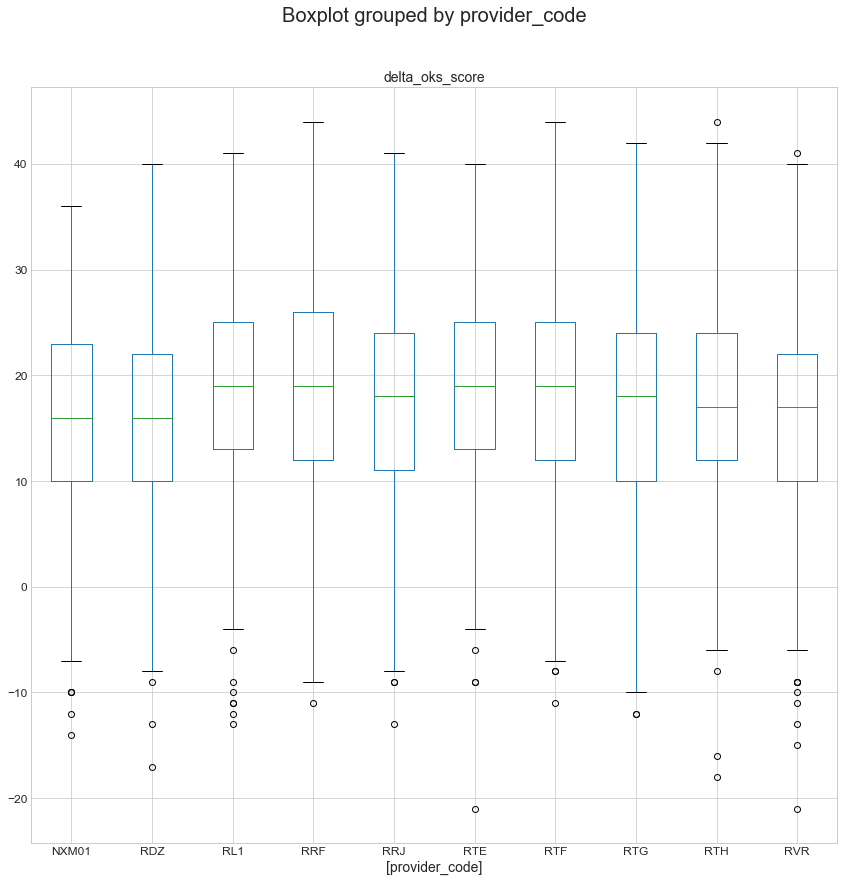

In [21]:
_top10_latest = (dfc.provider_code.isin(top10.index)) & (dfc.year=='2018/19')
dfc.loc[_top10_latest,['provider_code', 'delta_oks_score']].boxplot(by=['provider_code'], figsize=L);

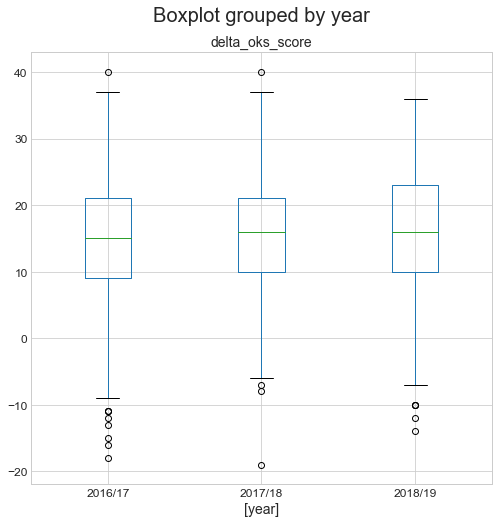

In [22]:
# lets look at a single provider and see whether delta_oks_score changes year-on-year
dfc.loc[(dfc.provider_code.isin(['NXM01'])),['year', 'delta_oks_score']].boxplot(by=['year'], figsize=S);

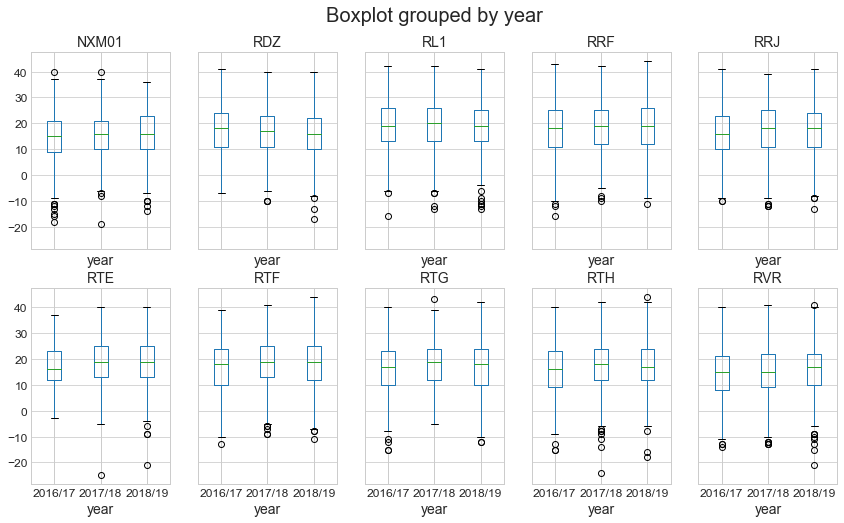

In [23]:
# bonus: how to create small multiples
# http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(14,8))
axes_list = [item for sublist in axes for item in sublist] 

for provider, df in dfc.loc[dfc.provider_code.isin(top10.index),:].groupby('provider_code'):
    ax = axes_list.pop(0)
    df.boxplot(column='delta_oks_score', by='year', ax=ax)
    ax.set_title(provider)

In [24]:
# Extra exercise: is there an association between size of a provider and Y
# group providers in 10 deciles by volume
provider_cat = pd.qcut(volume_provider_year.loc['2018/19',:], q=10)

### Discussion

#### **Question:** reconsider our choice of Y
- Is it useful to quantify treatment success?
- What limitations are there?

## Explore (X,Y)


### Visual data exploration: scattermatrix
At this stage of the process, it is often helpful to try different visualizations to explore the data.

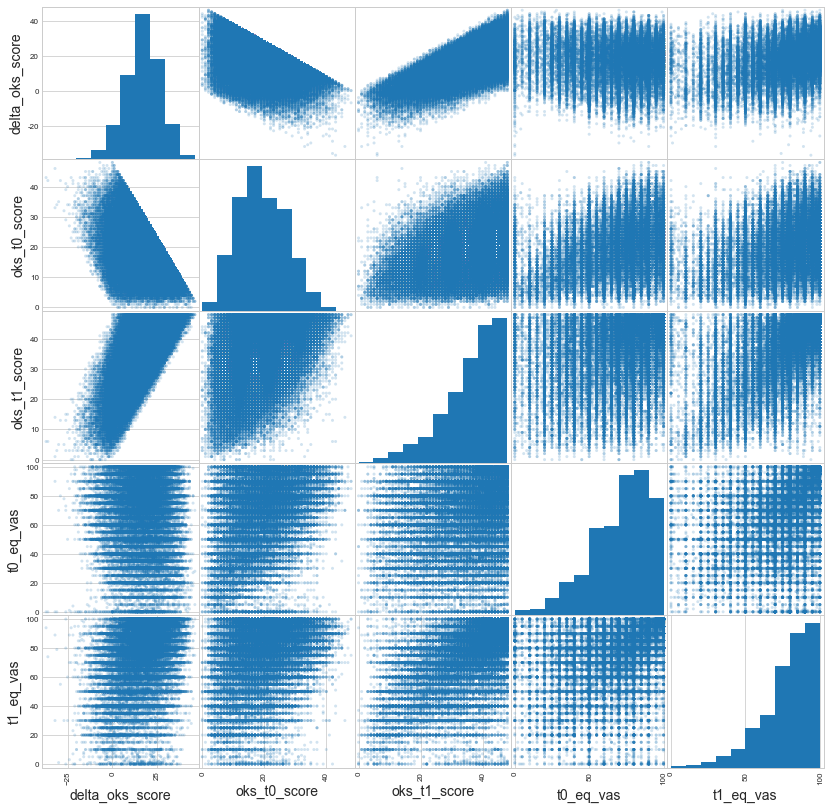

In [25]:
# 3-point scales don't look that interesting, let's zoom in on oks_score and eq_vas
# note some functions don't work with nullable integer Int64 (yet), so converting back to int64
oks_vas = ['delta_oks_score', 'oks_t0_score', 'oks_t1_score', 't0_eq_vas', 't1_eq_vas']
pd.plotting.scatter_matrix(dfc.loc[:,oks_vas].astype('int64'), figsize=L, alpha=0.2);

### Data preparation: second iteration

#### Ceiling effect
Clearly we need to do something to account for the ceiling effect. So in our second iteration we define a binary outcome parameter Y as 'good' when either `delta_oks_score` is above a certain threshold or `oks_t1_score` is above a certain absolute value.

In [26]:
def good_outcome(oks_t1, delta_oks):
  if oks_t1 > 43 or delta_oks > 13:
    return True
  else:
    return False

dfc['Y'] = dfc.apply(lambda row: good_outcome(row['oks_t1_score'], row['delta_oks_score']), axis=1)

#### Y by casemix variables (using Chi Square test)
Usually casemix attributes are strong predictors for outcomes. With chi-squared test we can assess which categorical variables have strong associations. Note that the casemix indicators are encoded with 1 (present) or 9 (missing).

Note that chi2 requires X and Y to be categorical. Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.

In [27]:
casemix = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
dfc.loc[:,casemix] = dfc.loc[:,casemix].replace(1, True).replace(9, False)
chi2_, pval = chi2(dfc.loc[:,casemix], dfc.Y)
chi = pd.DataFrame({'feature': casemix, 'chi2': chi2_, 'p': pval}).sort_values('chi2', ascending=False)
chi

,feature,chi2,p
3,circulation,311.24,1.17e-69
10,depression,194.76,2.91e-44
5,diabetes,144.67,2.54e-33
0,heart_disease,52.72,3.84e-13
2,stroke,21.59,3.37e-06
4,lung_disease,21.08,4.42e-06
6,kidney_disease,14.03,1.80e-04
8,liver_disease,9.50,2.05e-03
7,nervous_system,4.95,2.61e-02
1,high_bp,2.11,1.47e-01


### Explore some more: correlation plots
Assess whether the outcome Y has a correlation with size of provider?

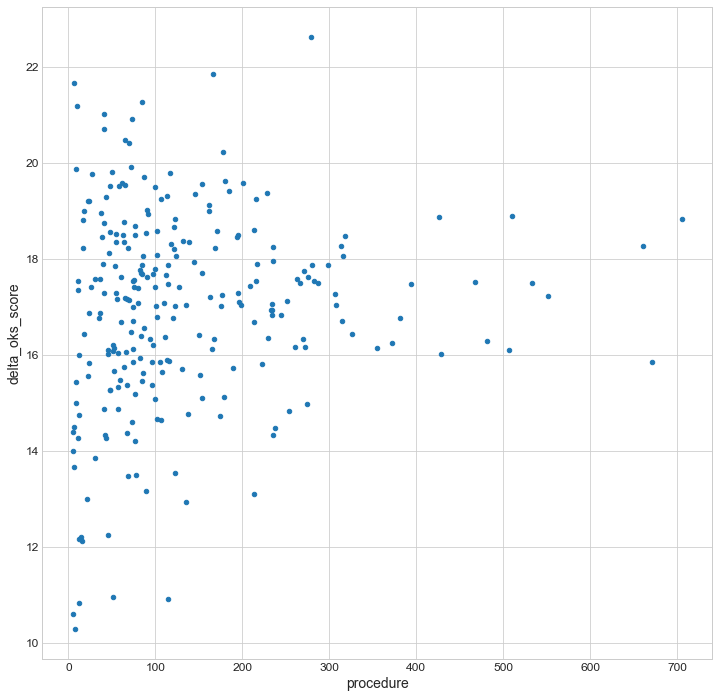

In [28]:
# group by providers for 2018/19
_provider2019 = dfc.loc[(dfc.year == '2018/19'),:].groupby('provider_code')

# count procedures, calculate mean delta_oks_score and plot
(pd.concat([_provider2019.count()['procedure'].sort_values(ascending=False),
          _provider2019.mean()['delta_oks_score']], axis=1)
   .plot(kind='scatter', x='procedure', y='delta_oks_score', figsize=M)
);

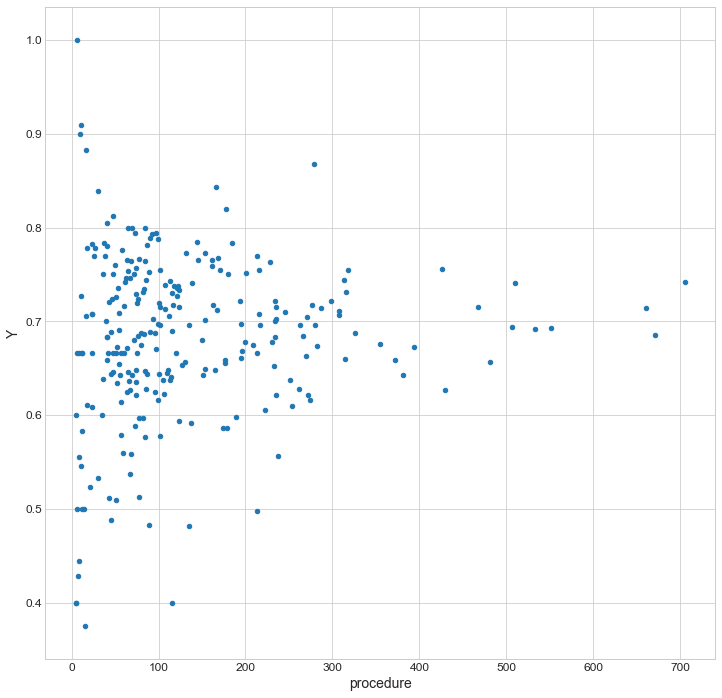

In [29]:
# same approach, using binary Y
(pd.concat([_provider2019.count()['procedure'].sort_values(ascending=False),
          _provider2019.mean()['Y']], axis=1)
   .plot(kind='scatter', x='procedure', y='Y', figsize=M)
);

**Extra exercise:** construct a funnelplot to assess which providers have significantly better c.q. poorer outcome within 95% confidence interval.

### Other things to look into
* Are there near-zero variance features (using `sklearn.feature_selection.VarianceThreshold)?
* Do infeasible combinations of variable values occur in the data (e.g. minors with a drivers license or pregnant males)? 
* A tree-model where Y is being predicted using a cluster of related X-variables, such as ROM-items
* Which variables are known / not known at the point of prediction?
* Which domains (work, health, family, lifestyle, therapy, etc etc) are covered?

# Conclusion and reflection

## Discussion of results

Looking at the different results, reflect on the meaning and usefulness of the outputs.
* To what extent are the chosen outcome variables meaningful?
* Does the data provide relevant and sufficiently detailed information to address the key question?
* What are the key uncertainties c.q. unknowns?


## Checklist for results from data understanding process
* assessment of the quality of the data (in terms of outliers and missings)
* input regarding the moment of prediction
* input for data cleaning (handling missing data; removing variables not known at time of prediction, near-zero variance variables, etc)
* input for feature engineering (adjusting variables based on tree-analyses, based on correlations, based on domain-analysis)
* input for defining the outcome variable Y
* input for defining the project in terms of generalizability (in case of missing Y values)
* input for choosing the project in case there are still multiple options at the table
* input for defining the scope of the project (e.g. limiting to a subgroup to get a better balanced outcome variable)
* a potential revision of the goal of your project
* input for which variables and combination of variables seem particularly relevant within the to-be-developed algorithms 